In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset,DataLoader
import os
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Subset, ConcatDataset
from scipy.special import logsumexp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        h = self.relu(self.fc1(x))
        mean = self.fc2_mean(h)
        log_var = self.fc2_logvar(h)
        return mean, log_var

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        h = self.relu(self.fc1(z))
        o = torch.clamp(self.sigmoid(self.fc2(h)), min=1e-8, max=1-1e-8)
        return o

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        mean, log_var = self.encoder(x)
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z = mean + eps * std
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mean, log_var

In [6]:
def loss_function(x, x_reconstructed, mean, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

In [7]:
def train(model, dataloader, optimizer, epoch,ifprint = False):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device).view(-1, 784)
        optimizer.zero_grad()
        x_reconstructed, mean, log_var = model(data)
        loss = loss_function(data, x_reconstructed, mean, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if ifprint:
        print('Epoch: {} | Train Loss: {:.4f}'.format(epoch, train_loss / len(dataloader.dataset)))
    return train_loss / len(dataloader)


In [8]:
def get_mnist():

    
    data=np.float64(np.load(datadir+'MNIST_data.npy'))
    labels=np.float32(np.load(datadir+'MNIST_labels.npy'))
    permutation = np.random.permutation(data.shape[0])
    data = data[permutation]
    labels = labels[permutation]
    data=np.float32(data)/255.
    train_dat=data[0:55000]
    train_labels=np.int32(labels[0:55000])
    val_dat=data[55000:60000]
    val_labels=np.int32(labels[55000:60000])
    test_dat=data[60000:70000]
    test_labels=np.int32(labels[60000:70000])
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

In [9]:
input_dim = 784
hidden_dim = 256
latent_dim = 20
learning_rate = 0.001
batch_size = 1000
epochs = 30

datadir='C:/Users/18383/Desktop/stat37601/'
tra,val,test=get_mnist()
train_loader = DataLoader(TensorDataset(torch.tensor(tra[0]),torch.tensor(tra[1])), batch_size=batch_size, shuffle=True)

model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch,True)

Epoch: 1 | Train Loss: 279.5123
Epoch: 2 | Train Loss: 194.6629
Epoch: 3 | Train Loss: 165.9215
Epoch: 4 | Train Loss: 151.8511
Epoch: 5 | Train Loss: 142.7140
Epoch: 6 | Train Loss: 137.0237
Epoch: 7 | Train Loss: 132.6328
Epoch: 8 | Train Loss: 128.5724
Epoch: 9 | Train Loss: 125.6400
Epoch: 10 | Train Loss: 123.3484
Epoch: 11 | Train Loss: 121.5537
Epoch: 12 | Train Loss: 120.0260
Epoch: 13 | Train Loss: 118.7257
Epoch: 14 | Train Loss: 117.6293
Epoch: 15 | Train Loss: 116.6181
Epoch: 16 | Train Loss: 115.8818
Epoch: 17 | Train Loss: 115.1259
Epoch: 18 | Train Loss: 114.5922
Epoch: 19 | Train Loss: 114.0010
Epoch: 20 | Train Loss: 113.4502
Epoch: 21 | Train Loss: 113.0582
Epoch: 22 | Train Loss: 112.5847
Epoch: 23 | Train Loss: 112.2324
Epoch: 24 | Train Loss: 111.8772
Epoch: 25 | Train Loss: 111.4871
Epoch: 26 | Train Loss: 111.2423
Epoch: 27 | Train Loss: 110.9201
Epoch: 28 | Train Loss: 110.6267
Epoch: 29 | Train Loss: 110.4137
Epoch: 30 | Train Loss: 110.1292


In [10]:
def visualize_reconstructed_images(model, dataloader, num_images=5):
    model.eval()
    data_iter = iter(dataloader)
    images, _ = data_iter.next()
    images = images.to(device).view(-1, 784)

    with torch.no_grad():
        reconstructed_images, mean, log_var = model(images)
        reconstructed_images = reconstructed_images.view(-1, 1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(10, 4))
    for i in range(num_images):
        axes[0, i].imshow(images[i].view(28, 28).cpu(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')

    plt.show()

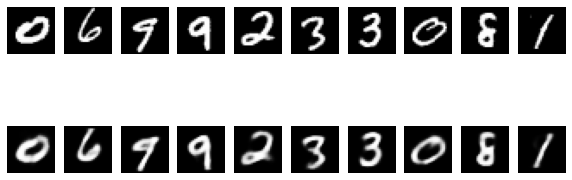

In [11]:
valid_loader = DataLoader(TensorDataset(torch.tensor(val[0]),torch.tensor(val[1])), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(torch.tensor(test[0]),torch.tensor(test[1])), batch_size=batch_size)
visualize_reconstructed_images(model, test_loader,10)

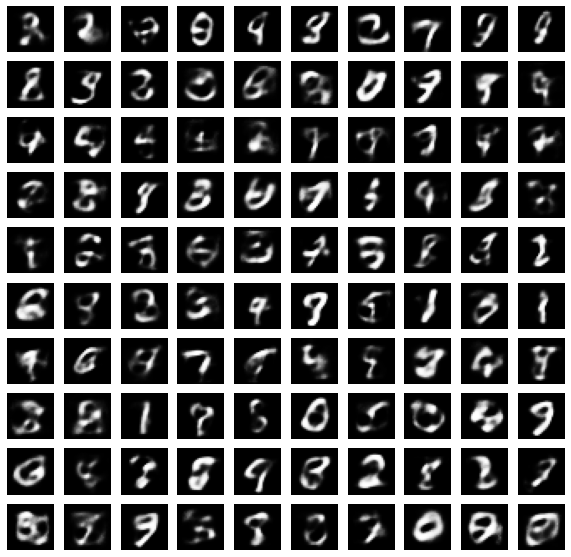

In [12]:
def generate_samples(model, latent_dim, num_samples=100):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated_samples = model.decoder(z).view(-1, 1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            axes[i, j].imshow(generated_samples[i * 10 + j].squeeze(), cmap='gray')
            axes[i, j].axis('off')

    plt.show()
    
generate_samples(model, latent_dim)

In [13]:
def calculate_fid(model, real_images, num_samples, latent_dim):
    model.eval()

    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated_samples = model.decoder(z).cpu().numpy()

    mu_real, mu_gen = np.mean(real_images, axis=0), np.mean(generated_samples, axis=0)
    cov_real, cov_gen = np.cov(real_images, rowvar=False), np.cov(generated_samples, rowvar=False)

    # Compute the FID score
    mu_diff = np.sum((mu_real - mu_gen) ** 2)
    cov_sqrt = sqrtm(cov_real.dot(cov_gen))
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real
    fid = mu_diff + np.trace(cov_real + cov_gen - 2 * cov_sqrt)

    return fid

In [14]:
def test_loss(model, dataloader):
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device).view(-1, 784)
            reconstructed_data, mean, log_var = model(data)

            loss = loss_function(data,reconstructed_data, mean, log_var)
            validation_loss += loss.item()

    validation_loss /= len(dataloader.dataset)
    return validation_loss

In [90]:
hidden_dims = [256, 512, 1024]
latent_dims = [10, 20, 40]

results = []
models = []
for hidden_dim in hidden_dims:
    for latent_dim in latent_dims:
        model = VAE(input_dim, hidden_dim, latent_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1, epochs + 1):
            train(model, train_loader, optimizer, epoch)
        models.append(model)
            
        fid_score = calculate_fid(model, tra[0], 2000, latent_dim)
        val_loss = test_loss(model, valid_loader)
            
        num_params = sum(p.numel() for p in model.parameters())
        results.append({
            'hidden_dim': hidden_dim,
            'latent_dim': latent_dim,
            'num_params': num_params,
            'valid_loss':val_loss,
            'fid_score': fid_score
        })

        print(f"Hidden Dim: {hidden_dim}, Latent Dim: {latent_dim}, "
            f"Num Params: {num_params}, FID Score: {fid_score:.4f},Valid Loss: {val_loss:.4f}")


Hidden Dim: 256, Latent Dim: 10, Num Params: 410404, FID Score: 10.1802,Valid Loss: 116.2055
Hidden Dim: 256, Latent Dim: 20, Num Params: 418104, FID Score: 7.0488,Valid Loss: 110.6818
Hidden Dim: 256, Latent Dim: 40, Num Params: 433504, FID Score: 6.6741,Valid Loss: 110.4105
Hidden Dim: 512, Latent Dim: 10, Num Params: 820004, FID Score: 9.6021,Valid Loss: 112.3954
Hidden Dim: 512, Latent Dim: 20, Num Params: 835384, FID Score: 6.2749,Valid Loss: 106.7625
Hidden Dim: 512, Latent Dim: 40, Num Params: 866144, FID Score: 6.0999,Valid Loss: 106.8785
Hidden Dim: 1024, Latent Dim: 10, Num Params: 1639204, FID Score: 9.3190,Valid Loss: 108.9862
Hidden Dim: 1024, Latent Dim: 20, Num Params: 1669944, FID Score: 5.8127,Valid Loss: 105.0126
Hidden Dim: 1024, Latent Dim: 40, Num Params: 1731424, FID Score: 5.5956,Valid Loss: 104.3646


Generally, FID score is positively correlated with loss value.

In [15]:
def compute_qk(model, dataloader, k):
    model.eval()
    qk_approx = 0
    n = len(dataloader.dataset)
    
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device).view(-1, 784)
            mean, log_var = model.encoder(data)
            qk_sum = []
            
            for _ in range(k):
                epsilon = torch.randn_like(log_var).to(device)
                z = mean + torch.exp(0.5 * log_var) * epsilon
                reconstructed_data = model.decoder(z) 
                p_x_given_z = torch.sum(data * torch.log(reconstructed_data) + (1 - data) * torch.log(1 - reconstructed_data), dim=1)
                q_z_given_x = -0.5 * torch.sum((z - mean)**2 / torch.exp(log_var) + log_var + np.log(2 * np.pi), dim=1)
                p_z = -0.5 * torch.sum(z**2 + np.log(2 * np.pi), dim=1)

                joint_p_xz = p_x_given_z + p_z
                log_ratio = joint_p_xz - q_z_given_x

                qk_sum.append(log_ratio.cpu().numpy())
            qk_sum = logsumexp(qk_sum,axis=0)-np.log(k)

            
            qk_approx += np.sum(qk_sum)
            
            
    qk_approx /= n
    return -qk_approx


def compute_qks(model, dataloader, k):
    model.eval()
    qk_approx = []
    n = len(dataloader.dataset)
    
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device).view(-1, 784)
            mean, log_var = model.encoder(data)
            qk_sum = []
            
            for _ in range(k):
                epsilon = torch.randn_like(log_var).to(device)
                z = mean + torch.exp(0.5 * log_var) * epsilon
                reconstructed_data = model.decoder(z) 
                p_x_given_z = torch.sum(data * torch.log(reconstructed_data) + (1 - data) * torch.log(1 - reconstructed_data), dim=1)
                q_z_given_x = -0.5 * torch.sum((z - mean)**2 / torch.exp(log_var) + log_var + np.log(2 * np.pi), dim=1)
                p_z = -0.5 * torch.sum(z**2 + np.log(2 * np.pi), dim=1)

                joint_p_xz = p_x_given_z + p_z
                log_ratio = joint_p_xz - q_z_given_x

                qk_sum.append(log_ratio.cpu().numpy())
            qk_sum = logsumexp(qk_sum,axis=0)-np.log(k)

            
            qk_approx.extend(-qk_sum)
            
    return qk_approx

In [207]:
k_values = [10, 100, 1000]

for model in models:
    model.to(device)
    for k in k_values:
        neg_qk = compute_qk(model, valid_loader, k)
        print(f" k: {k}, -Q~_k: {neg_qk:.4f}")

 k: 10, -Q~_k: 114.0073
 k: 100, -Q~_k: 113.1943
 k: 1000, -Q~_k: 112.8389
 k: 10, -Q~_k: 107.7808
 k: 100, -Q~_k: 106.5713
 k: 1000, -Q~_k: 106.0047
 k: 10, -Q~_k: 107.0504
 k: 100, -Q~_k: 105.8476
 k: 1000, -Q~_k: 105.1947
 k: 10, -Q~_k: 110.2798
 k: 100, -Q~_k: 109.6173
 k: 1000, -Q~_k: 109.3125
 k: 10, -Q~_k: 104.0032
 k: 100, -Q~_k: 102.9678
 k: 1000, -Q~_k: 102.4233
 k: 10, -Q~_k: 103.8769
 k: 100, -Q~_k: 102.7044
 k: 1000, -Q~_k: 102.1447
 k: 10, -Q~_k: 107.1450
 k: 100, -Q~_k: 106.5345
 k: 1000, -Q~_k: 106.2734
 k: 10, -Q~_k: 102.1184
 k: 100, -Q~_k: 101.1418
 k: 1000, -Q~_k: 100.6288
 k: 10, -Q~_k: 101.6444
 k: 100, -Q~_k: 100.5393
 k: 1000, -Q~_k: 100.0726


$− \tilde{Q}_k$ does decrease as a function of k.It seems to converge slowly.

In [16]:
def extract_embeddings(model, dataloader):
    model.eval()
    embeddings = []
    targets = []

    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device).view(-1, 784)
            mean, log_var = model.encoder(data)
            embedding = torch.cat((mean, log_var), dim=1).cpu().numpy()
            embeddings.append(embedding)
            targets.append(target.numpy())

    return np.vstack(embeddings), np.concatenate(targets)


In [ ]:
hidden_dim = 512
s = [10, 40, 80, 160]
small_loader = DataLoader(TensorDataset(torch.tensor(tra[0][0:5000]),torch.tensor(tra[1][0:5000])), batch_size=batch_size, shuffle=True)
def embedding_classify(small_loader):
    n = len(small_loader.dataset)

    emb_accs = []
    for latent_dim in s:
        model = VAE(input_dim, hidden_dim, latent_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1, epochs + 1):
            train(model, small_loader, optimizer, epoch)
        embeddings_train,targets_train = extract_embeddings(model, small_loader)
        embeddings_val,targets_val = extract_embeddings(model, valid_loader)

        svc_emb = SVC(kernel='linear')
        svc_emb.fit(embeddings_train, targets_train)
        emb_preds = svc_emb.predict(embeddings_val)
        emb_acc = accuracy_score(targets_val, emb_preds)
        print(f"Accuracy with VAE embeddings with s={latent_dim}: {emb_acc:.4f}")
        emb_accs.append(emb_acc)

    svc_raw = SVC(kernel='linear',max_iter=10000)
    svc_raw.fit(tra[0][0:n], tra[1][0:n])
    raw_preds = svc_raw.predict(val[0])
    raw_acc = accuracy_score(val[1], raw_preds)
    print(f"Accuracy with raw data: {raw_acc=:.4f}")
    
embedding_classify(small_loader)

large_loader = DataLoader(TensorDataset(torch.tensor(tra[0][5000:35000]),torch.tensor(tra[1][5000:35000])), batch_size=batch_size, shuffle=True)
embedding_classify(large_loader)

Accuracy with VAE embeddings with s=10: 0.8424
Accuracy with VAE embeddings with s=40: 0.9048
Accuracy with VAE embeddings with s=80: 0.9086
Accuracy with VAE embeddings with s=160: 0.9162
Accuracy with raw data: raw_acc=0.9076
Accuracy with VAE embeddings with s=10: 0.9004


In [209]:
def filter_class(dataset, target_class):
    indices = [i for i, (_, label) in enumerate(dataset) if label == target_class]
    return Subset(dataset, indices)

def train_vae(dataloader):
    model = VAE(input_dim, hidden_dim, latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(1, epochs + 1):
        train(model, dataloader, optimizer, epoch)
    return model

hidden_dim = 1024
latent_dim = 40
class_vaes = [train_vae(DataLoader(filter_class(train_loader.dataset, target_class=i), batch_size=batch_size, shuffle=True)) for i in range(10)]

def classify_vae(test_data, k):
    likelihoods = []

    for class_vae in class_vaes:
        qk = compute_qks(class_vae, test_data, k)
        likelihoods.append(qk)

    return np.argmin(likelihoods,axis = 0)


total = 10000
k_values = [10, 100]

for k in k_values:
    prediction = classify_vae(test_loader, k)
    correct = sum(prediction == test[1])

    error_rate = 1 - correct / total
    print(f"Error rate for k={k}: {error_rate:.4f}")

Error rate for k=10: 0.0386
Error rate for k=100: 0.0382
